# Undersampling & Oversampling

Undersampling aims to decrease the number of instances from the overrepresented class in a data set, they are said to be unbalanced. Unbalanced refers to highly unequal or uneven distribution of classes. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from imblearn.over_sampling import SMOTE #Using nearest neighbors algorithm to generate new and synthetic data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier #Importing random forest module

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from preprocessing_ml import *

Importing the preprocessing module for the Exeter NatSci Machine Learning Group.....
Successfully imported the preprocessing module


In [2]:
###Importing the data
dataframe = pd.read_csv("framingham.csv")
print(dataframe.shape)

(4240, 16)


In [3]:
###Seeing the difference between CHD after 10 years and no-CHD.

CHD_count = dataframe.TenYearCHD.value_counts() #Shows the count of no-CHD and CHD after 10 y
print('The CHD after ten years has a ratio of approximately {} to 1.'.format(int(CHD_count[0] / CHD_count[1])))

The CHD after ten years has a ratio of approximately 5 to 1.


In [4]:
def preprocessing(dataframe, features, n, o=1):
    if o == 1:
        dataframe = outliers(dataframe, v = 1)
    
    dataframe = chose_features(dataframe, features = features, n_features = n, vv = 1)
    dataframe = drop_missing(dataframe, v = 1)
    return dataframe



#dataframe = preprocessing(dataframe, 12)
#dataframe = dataframe.drop(['glucose'], axis=1);

In [ ]:
features = ['sysBP', 'age', 'cigsPerDay', 'totChol', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds', 'male', 'BMI', 'TenYearCHD']
dataframe = preprocessing(dataframe, features, -1, 1)

In [5]:
def scores(name, y_test, pred, v):
    accuracy = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)

    if v == 'y':
        print("The accuracy score for {} is: {}%.".format(name, round(accuracy, 3) * 100))
        print("The f1 score for {} is: {}%.".format(name, round(f1, 3) * 100))
        print("The precision score for {} is: {}%.".format(name, round(precision, 3) * 100))
        print("The recall score for {} is: {}%.".format(name, round(recall, 3) * 100))        
        return(accuracy, f1, precision, recall)
    elif v == 'n':
        return(accuracy, f1, precision, recall)
    else:
        print("Error: please choose 'y' or 'n'.")

In [ ]:
def confusion(dataframe, name):
    sns.heatmap(pd.DataFrame(dataframe), annot=True , fmt='g')
    plt.title('Confusion matrix {}\n'.format(name), y=1.1)

In [ ]:
def model(classifier, name, X_train, X_test, y_train, y_test, v):
    classifier.fit(X_train, y_train)
    classifier_pred = classifier.predict(X_test)
    score = scores(name, y_test, classifier_pred, v)

    accuracy = score[0]
    f1 = score[1]
    precision = score[2]
    recall = score[3]
    
    confusion(confusion_matrix(y_test, classifier_pred), name)

    return(accuracy, f1, precision, recall)

In [ ]:
def oversample(dataframe, ratio):
    X_train, X_test, y_train, y_test = split_data(dataframe, dep_var='TenYearCHD', test_size = 0.2, v = 1, r_state = 0)
    sm = SMOTE(random_state = 0, ratio = ratio)
    X_train, y_train = sm.fit_sample(X_train, y_train)
    model(RandomForestClassifier(n_estimators=120, bootstrap=True), 'Random Forest', X_train, X_test, y_train, y_test, 'y');

In [ ]:
def no_resample(dataframe):
    X_train, X_test, y_train, y_test = split_data(dataframe, dep_var='TenYearCHD', test_size = 0.2, v = 1, r_state = 0)
    model(RandomForestClassifier(n_estimators=120, bootstrap=True), 'Random Forest', X_train, X_test, y_train, y_test, 'y');

In [ ]:
def undersample(dataframe, ratio):
    dataframe = dataframe.sample(frac=1,random_state=1)
    
    CHD_count = dataframe.TenYearCHD.value_counts()

    CHD_data = dataframe.loc[dataframe['TenYearCHD'] == 1]
    non_CHD_data = dataframe.loc[dataframe['TenYearCHD'] == 0].sample(n = (CHD_count[1]), random_state = 1)
    
    dataframe = pd.concat([CHD_data, non_CHD_data])
    
    CHD_count = dataframe.TenYearCHD.value_counts() #Shows the count of no-CHD and CHD after 10 y
    print('The CHD after ten years has a ratio of approximately {} to 1.'.format(int(CHD_count[0] / CHD_count[1])))
    
    X_train, X_test, y_train, y_test = split_data(dataframe, dep_var='TenYearCHD', test_size = 0.2, v = 1, r_state = 0)
    model(RandomForestClassifier(n_estimators=120, bootstrap=True), 'Random Forest', X_train, X_test, y_train, y_test, 'y');

In [ ]:
no_resample(dataframe)

In [ ]:
oversample(dataframe, 1)

In [ ]:
undersample(dataframe, 1)

In [ ]:
def model_new(classifier, name, X_train, X_test, y_train, y_test, cut_off, v):
    classifier.fit(X_train, y_train)
    classifier_pred = classifier.predict(X_test)

    
    predictions = classifier.predict_proba(X_test)
    predicted = (predictions[:,1] >= cut_off).astype('int')

    score = scores(name, y_test, predicted, v)
    
    accuracy = score[0]
    f1 = score[1]
    precision = score[2]
    recall = score[3]
    
    confusion(confusion_matrix(y_test, predicted), name)

    return(accuracy, f1, precision, recall)

In [ ]:
def resample(dataset, r_state=0, ratio_1_to_0=1.0, test_size=0.2, v=0):
    '''Resample dataset by upsampling, increasing number of minority samples using SMOTE, a package that creates synthetic values when upsampling
    - dataset: Pandas Dataframe. Data to upsample
    - r_state (optional): int. Random state to use
    - ratio_1_to_0 (optional): float. Ratio to resample to.
    - v (optional): Verbose
    Returns X_train, x_test, Y_train, y_test
    '''
    from imblearn.over_sampling import SMOTE  # Using nearest neighbors algorithm to generate new and synthetic data
    import pandas as pd

    # Splitting into test and train
    train_data = dataset.sample(frac=(1 - test_size), random_state=r_state)
    test_data = pd.concat([train_data, dataset]).drop_duplicates(keep=False)

    # Splitting into majority and minority classes
    X_train = train_data.drop('TenYearCHD', axis=1)
    y_train = train_data[['TenYearCHD']]
    X_test = test_data.drop('TenYearCHD', axis=1)
    y_test = test_data[['TenYearCHD']]
    
    sm = SMOTE(random_state=r_state, ratio=ratio_1_to_0)

    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
    y_train_res = pd.DataFrame(y_train_res, columns=y_train.columns)

    if v == 1:
        print("\nUpsampling data using SMOTE")
        print('Splitting data set into training and test sets....')
        print("The ratio of train data to test data is {}:1\n".format((train_data.shape[0]) / (dataset.shape[0])))
        print("The original ratio of CHD to non-CHD was: {}: 1".format(dataset.TenYearCHD.value_counts()[0]/dataset.TenYearCHD.value_counts()[1]))
        print("The new ratio of CHD to non-CHD is: {}: 1".format(X_train_res.shape[0]/y_train_res.shape[0]))

    return X_train_res, X_test, y_train_res, y_test

In [ ]:
def new_2(dataframe):
    features = ['sysBP', 'age', 'cigsPerDay', 'totChol', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds', 'male', 'BMI', 'TenYearCHD']
    dataframe = preprocessing(dataframe, features, -1, 1)
    data = smote(dataframe, v = 1)
    
    X_train = data[0]
    X_test = data[1]
    y_train = data[2]
    y_test = data[3]
    
    model_new(RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=0), 'Random Forest', X_train, X_test, y_train, y_test, 0.3, 'y');

In [ ]:
new_2(dataframe)

In [ ]:
def new_3(dataframe):
    features = ['sysBP', 'age', 'cigsPerDay', 'totChol', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds', 'male', 'BMI', 'TenYearCHD']
    dataframe = preprocessing(dataframe, features, -1, o=1)
    data = smote(dataframe, v = 0)
    
    X_train = data[0]
    X_test = data[1]
    y_train = data[2]
    y_test = data[3]
    
    interval = np.linspace(0,1,20)    
    f1 = []
    for i in range(len(interval)):
        f1.append(model_new(RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=0), 'Random Forest', X_train, X_test, y_train, y_test, interval[i], 'n')[1]);
        
    return f1

In [ ]:
def new_4(dataframe):
    features = ['sysBP', 'age', 'cigsPerDay', 'totChol', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds', 'male', 'BMI', 'TenYearCHD']
    data = preprocessing(dataframe, features, -1, o=0)
    data = smote(data, v = 0)
    
    X_train = data[0]
    X_test = data[1]
    y_train = data[2]
    y_test = data[3]
    
    interval = np.linspace(0,1,20)    
    f1 = []
    for i in range(len(interval)):
        f1.append(model_new(RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=0), 'Random Forest', X_train, X_test, y_train, y_test, interval[i], 'n')[1]);
        
    return f1

In [ ]:
f1 = new_3(dataframe)
f2 = new_4(dataframe)

In [ ]:
import matplotlib.pyplot as plt
interval = np.linspace(0,1,20)    
plt.plot(interval, f1, label='outliers removal')
plt.plot(interval, f2, label='outlier remain')
plt.legend()

In [ ]:
def new_5(dataframe):
    features = ['sysBP', 'age', 'cigsPerDay', 'totChol', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds', 'male', 'BMI', 'TenYearCHD']
    dataframe = preprocessing(dataframe, features, -1, o=1)
    data = smote(dataframe, v = 0)
    
    X_train = data[0]
    X_test = data[1]
    y_train = data[2]
    y_test = data[3]
    
    model_new(RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=0), 'Random Forest', X_train, X_test, y_train, y_test, 0.3, 'n');
    
    

In [14]:
def new_6(dataframe):
    from sklearn.ensemble import RandomForestClassifier
    
    features = ['sysBP', 'age', 'cigsPerDay', 'totChol', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds', 'male', 'BMI', 'TenYearCHD']
    dataframe = preprocessing(dataframe, features, -1, o=1)
    data = smote(dataframe, v = 0)
    
    X_train = data[0]
    X_test = data[1]
    y_train = data[2]
    y_test = data[3]
    
    classifier = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=0)
    
    classifier.fit(X_train, y_train)
    classifier_pred = classifier.predict(X_test)
    classifier_probs = classifier.predict_proba(X_test)[:, 1]
    predicted = (classifier_pred >= 0.2).astype('int')
    
    y_pred_prob_yes = classifier.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
    plt.plot(fpr,tpr,label ='RF')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    print('roc auc for RF:',roc_auc_score(y_test,y_pred_prob_yes[:,1]))
    
    score = scores("Random Forest", y_test, predicted, v = 'y')
    
    
    accuracy = score[0]
    f1 = score[1]
    precision = score[2]
    recall = score[3]
    

Now dropping rows with outliers values....
	 * Dropped 17 rows 0.4%. 4223 rows remaining
Now selecting chosen features....
	 * Chosen features:  ['sysBP', 'age', 'cigsPerDay', 'totChol', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds', 'male', 'BMI', 'TenYearCHD']
	 * Dropped features:  ['education', 'currentSmoker', 'prevalentStroke', 'heartRate', 'glucose']
Now dropping rows with missing values....
	 * Dropped 149 rows 3.5%. 4074 rows remaining



/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


roc auc for RF: 0.6394186250218985
The accuracy score for Random Forest is: 83.1%.
The f1 score for Random Forest is: 18.8%.
The precision score for Random Forest is: 28.599999999999998%.
The recall score for Random Forest is: 14.000000000000002%.


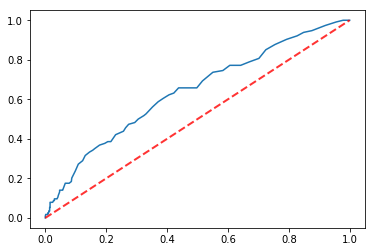

In [15]:
new_6(dataframe)